# Part 1: Object localization



During this first part, I am going to work on **object localization**. It is not quite Object Detection, but we will get there at some point (promise).

The task will be to locate and classify objects in images that you generated.

I will generate images containing **squares, triangles and circles**, and train a **neural network** that **I will design** in order to correctly identify the shape and its location.

![](https://miro.medium.com/max/1400/0*skhg8QlOKh33uhtl.)

## 1: Image generation

Create some code that can generate a **squared image** with a random **black rectangular shape** inside of it, as shown above.


In [ ]:
# Libraries and dependencies
import cv2
import numpy as np
from numpy.random import randint as randint
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import tensorflow as tf
from tensorflow import keras
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Conv2D, MaxPooling2D, Flatten
from sklearn.utils import shuffle
from tensorflow.keras import Model, Input
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [ ]:
def generate_squared_image(n_images=1, img_size=(8,8)):

  assert n_images > 0, "The the number of images to generate must be > 0."
  assert img_size[0] == img_size[1], "The img size  must be a square."

  imgs, rectangle_pos = np.full((n_images, img_size[0], img_size[1], 1), 255.0), np.zeros((n_images, 4))

  # Generate black rectangle
  for n in range(n_images):
    w, h = randint(2, img_size[0]-2), randint(0, img_size[0]-2)
    x, y = randint(2, img_size[0] - w), randint(0, img_size[0] - h)
    rectangle_pos[n] = np.array([x, y, w, h])
    imgs[n, x:x+w, y:y+h] = 0.0

  return imgs, rectangle_pos

## 2: Dataset generation

Using the code  above, generate a training set, a validation set, and a testing set. Even though the placement of the rectangle is random, you have to keep the localization information in the dataset to train your network.

In [ ]:
IMG_SIZE = 32
# Generate our dataset
imgs, bx = generate_squared_image(n_images=60000, img_size=(IMG_SIZE,IMG_SIZE))
bx = np.array(bx)

print('Images: ', imgs.shape, ', Rectangle pos: ', bx.shape)

Images:  (60000, 32, 32, 1) , Rectangle pos:  (60000, 4)


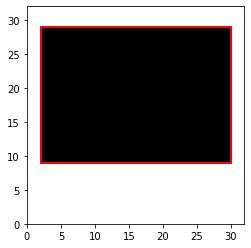

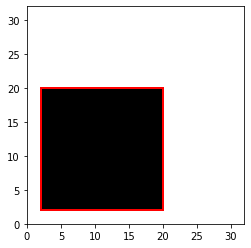

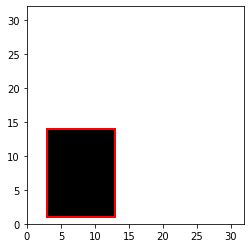

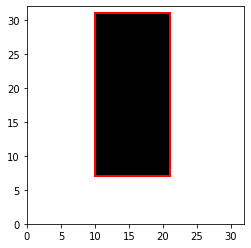

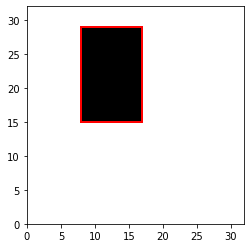

In [ ]:
# Visualize generated images
n_imgs = 5
for idx in range(0,n_imgs):
    fig, ax = plt.subplots()
    ax.imshow(imgs[idx].squeeze().T, cmap='gray', interpolation='none', origin='lower', extent=[0, imgs[idx].shape[0], 0, imgs[idx].shape[1]])
    rect = patches.Rectangle((bx[idx][0], bx[idx][1]), bx[idx][2], bx[idx][3], ec='r', fc='none', lw=2)
    ax.add_patch(rect)

    plt.show()


In [ ]:
# Normalization of data
w_imgs = (imgs / 255.0) - 0.5
w_bx = bx  / imgs.shape[1] # Normalization

print(f"Images shape: {w_imgs.shape}, images mean: {np.mean(w_imgs)}, images variance: {np.std(w_imgs)}")
print(f"Rectangle pos mean: {np.mean(w_bx)}, Rectangle pos variance: {np.std(w_bx)}")

Images shape: (60000, 32, 32, 1), images mean: 0.28051494140625, images variance: 0.4138977743934461
Rectangle pos mean: 0.36719518229166664, Rectangle pos variance: 0.2580262725267124


In [ ]:
# Split the data of images, labels and their annotations
TRAIN_SIZE = int(w_imgs.shape[0]*0.6)
VAL_TEST_SIZE = int(w_imgs.shape[0]*0.2)

train_images, val_images, test_images, check_test_images = w_imgs[:TRAIN_SIZE], w_imgs[TRAIN_SIZE:TRAIN_SIZE+VAL_TEST_SIZE], w_imgs[-VAL_TEST_SIZE:], imgs[-VAL_TEST_SIZE:]
train_boxes, val_boxes, test_boxes, check_test_boxes = w_bx[:TRAIN_SIZE], w_bx[TRAIN_SIZE:TRAIN_SIZE+VAL_TEST_SIZE], w_bx[-VAL_TEST_SIZE:], bx[-VAL_TEST_SIZE:]

print('Train images: ', train_images.shape, ', Train rectangle pos: ', train_boxes.shape)
print('Validation images: ', val_images.shape, ', Validation rectangle pos: ', val_boxes.shape)
print('Test images: ', test_images.shape, ', Test rectangle pos: ', test_boxes.shape)

Train images:  (36000, 32, 32, 1) , Train rectangle pos:  (36000, 4)
Validation images:  (12000, 32, 32, 1) , Validation rectangle pos:  (12000, 4)
Test images:  (12000, 32, 32, 1) , Test rectangle pos:  (12000, 4)


## 3: Neural network implementation

Implement a neural network that will take an image as input, and output the localization of the black rectangle (x,y,w,h).


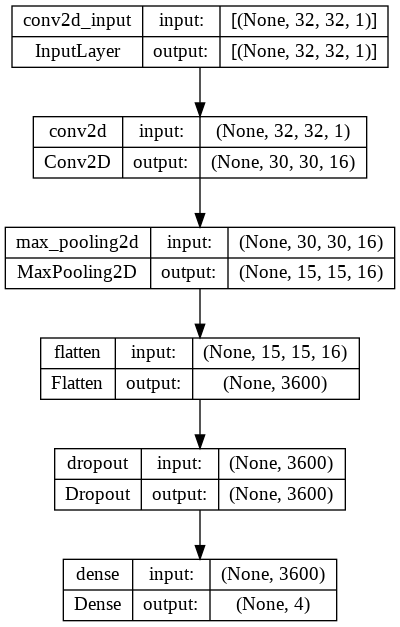

In [ ]:
model = Sequential()

model.add(Conv2D(16, kernel_size=3, activation="relu", input_shape=(IMG_SIZE, IMG_SIZE, 1)))
model.add(MaxPooling2D(pool_size=2))

model.add(Flatten())
model.add(Dropout(rate=0.3))

model.add(Dense(units=4))

plot_model(model, show_shapes=True, show_layer_names=True)

## 4: Neural network training

Train the neural network on the dataset that you generated. Use the training set for training, and the validation set for validation.


In [ ]:
tf.config.set_soft_device_placement(True)
tf.debugging.set_log_device_placement(True)

model.compile(optimizer='adam', loss='mse')
training_history = model.fit(train_images, train_boxes, epochs=8, validation_data=(val_images, val_boxes), verbose=2)

Epoch 1/8
1125/1125 - 13s - loss: 0.0087 - val_loss: 0.0048 - 13s/epoch - 12ms/step
Epoch 2/8
1125/1125 - 3s - loss: 0.0050 - val_loss: 0.0041 - 3s/epoch - 3ms/step
Epoch 3/8
1125/1125 - 3s - loss: 0.0046 - val_loss: 0.0037 - 3s/epoch - 2ms/step
Epoch 4/8
1125/1125 - 3s - loss: 0.0042 - val_loss: 0.0035 - 3s/epoch - 3ms/step
Epoch 5/8
1125/1125 - 3s - loss: 0.0039 - val_loss: 0.0030 - 3s/epoch - 2ms/step
Epoch 6/8
1125/1125 - 3s - loss: 0.0037 - val_loss: 0.0028 - 3s/epoch - 3ms/step
Epoch 7/8
1125/1125 - 3s - loss: 0.0036 - val_loss: 0.0029 - 3s/epoch - 2ms/step
Epoch 8/8
1125/1125 - 3s - loss: 0.0035 - val_loss: 0.0027 - 3s/epoch - 3ms/step


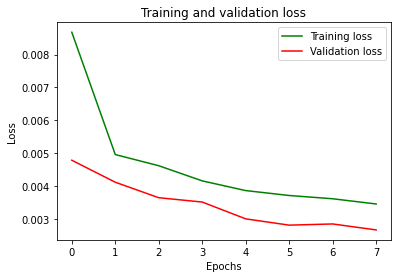

In [ ]:
plt.plot(training_history.epoch, training_history.history['loss'], 'g', label='Training loss')
plt.plot(training_history.epoch, training_history.history['val_loss'], 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## 5: Neural network evaluation

Evaluate the neural network on the test set.

In [ ]:
def iou_metric(y_true, y_pred):
  """
  Calculate IoU
  Args:
      y_true: real position of the element to detect
      y_pred: predicted position of the element to detect

  Returns:
      iou metric: return the IoU metric calculated from the parameters
  """

  x_true, y_true, w_true, h_true = y_true[0], y_true[1], y_true[2], y_true[3]
  x_pred, y_pred, w_pred, h_pred = y_pred[0], y_pred[1], y_pred[2], y_pred[3]

  w_i = min(x_true + w_true, x_pred + w_pred) - max(x_true, x_pred)
  h_i = min(y_true + h_true, y_pred + h_pred) - max(y_true, y_pred)

  if w_i <= 0 or h_i <= 0:
    return 0.0
  else:
    return np.round((w_i * h_i) / (w_pred * h_pred + w_true * h_true - (w_i * h_i)),2)

In [ ]:
prediction = model.predict(test_images)

375/375 [==============================] - 1s 2ms/step


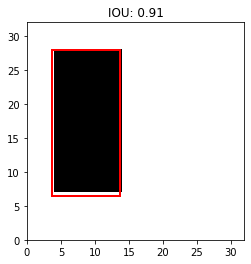

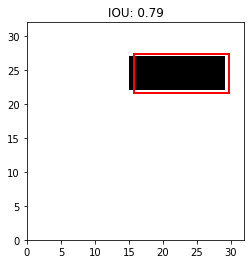

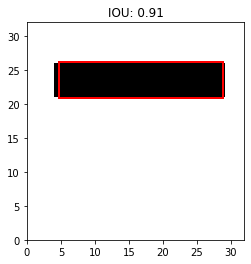

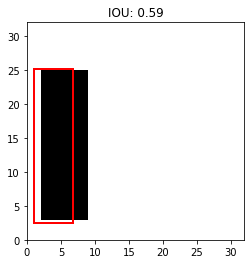

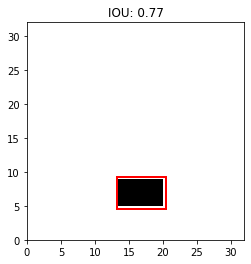

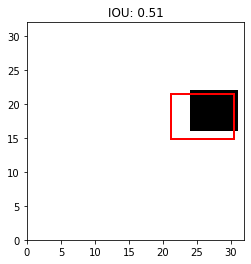

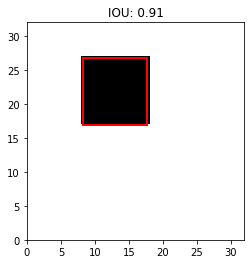

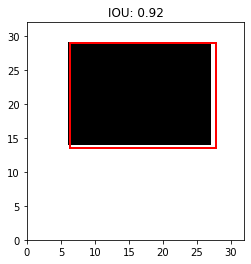

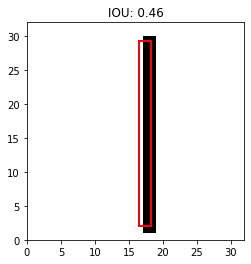

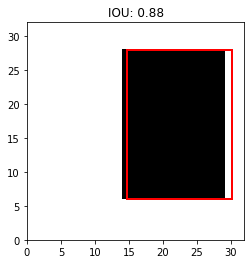

In [ ]:
num_plots=10
pred_location = prediction * IMG_SIZE
pred_location.shape


for img_idx in range(0, num_plots):
  fig, ax = plt.subplots()
  ax.imshow(check_test_images[img_idx].squeeze().T, cmap='gray', interpolation='none', origin='lower', extent=[0, check_test_images[img_idx].shape[0], 0, check_test_images[img_idx].shape[1]])
  rect = patches.Rectangle((pred_location[img_idx][0], pred_location[img_idx][1]), pred_location[img_idx][2], pred_location[img_idx][3], ec='r', fc='none', lw=2)
  ax.add_patch(rect)
  ax.title.set_text(f'IOU: {iou_metric(pred_location[img_idx],check_test_boxes[img_idx])}')

  plt.show()

In [ ]:
iou_list = []
for idx in range(0, test_images.shape[0]):
    iou_list.append(iou_metric(pred_location[img_idx], check_test_boxes[img_idx]))

print(f"Mean IoU: {(sum(iou_list)/test_images.shape[0])*100}")

Mean IoU: 87.99999999998943


## 6: Generating different shapes



In [ ]:
def generate_figures_images(n_images=1, img_size=(8,8), rgb=False, col_rect=(0,0,0), col_circle=(0,0,0), col_triangle=(0,0,0)):

  assert img_size[0] == img_size[1], "The img size  must be a square."

  if rgb: imgs = np.full((n_images, img_size[0], img_size[1], 3), 255.0)
  else: imgs = np.full((n_images, img_size[0], img_size[1], 1), 255.0)

  label_pos = np.zeros((n_images, 7))

  # Generate black rectangle
  for n in range(n_images):

    shape = np.random.choice([1,2,3])
    # Generate the rectangle
    if shape == 1:
      # Top left corner
      x, y = randint(2, img_size[0], 2)
      # Width and height
      w, h = randint(2, abs(img_size[0] - x/2)), randint(2, abs(img_size[0] - y/2))
      # Rectangle to image
      pto1, pto2 = (x, y), (x+w, y+h)
      cv2.rectangle(imgs[n], pto1, pto2, col_rect, -1)
      # Save x, y, w, h
      label_pos[n] = np.array([1, 0, 0, float(x), float(y), float(w)+1, float(h)+1])
    else:
          # Generate circle
          if shape == 2:
            # Radius
            radius = int(0.5*randint(2, (img_size[0]/2)-1))
            # Center
            x = randint(radius, img_size[0] - radius)
            y = randint(radius, img_size[0] - radius)
            cv2.circle(imgs[n], (x, y), radius, col_circle, -1)
            # Calculate circle(x, y, w, h)
            label_pos[n] = np.array([0, 1, 0, float(x)-radius, float(y)-radius, float(radius*2)+1, float(radius*2)+1])
          # Generate triangle
          else:
            # Top left corner
            x, y = randint(2, img_size[0], 2)
            # Width and height
            w, h = randint(2, abs(img_size[0] - x/2)), randint(2, abs(img_size[0] - y/2))
            # Points x,y,w,h
            pts = [(x,y), (x+w, y+h), (x+w, y), (x, y+h)]
            # Edges for the triangle
            pts.pop(randint(0, len(pts)-1))
            cv2.drawContours(imgs[n], [np.array(pts)], 0, col_triangle, -1)

            label_pos[n] = np.array([0, 0, 1, float(x), float(y), float(w)+1, float(h)+1])


  return imgs, label_pos

In [ ]:
IMG_SIZE = 32
imgs, bx = generate_figures_images(n_images=99999, img_size=(IMG_SIZE,IMG_SIZE))

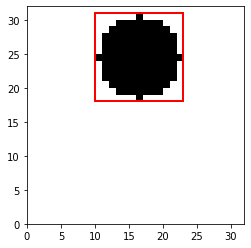

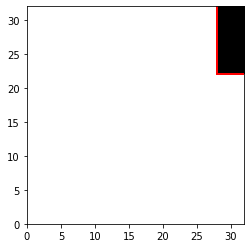

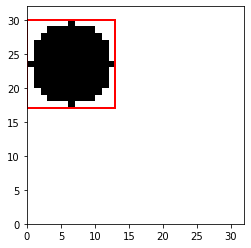

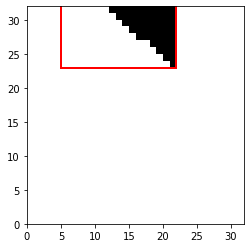

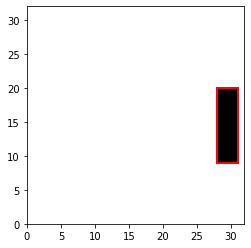

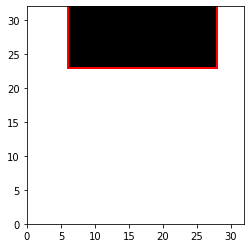

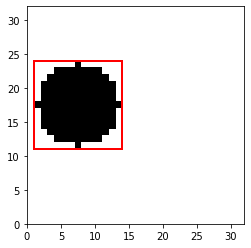

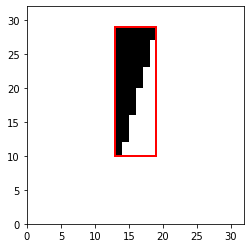

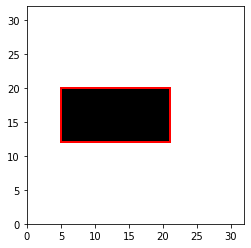

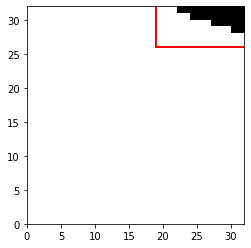

In [ ]:
# Visualize generated images
n_imgs = 10
for idx in range(0,n_imgs):
    fig, ax = plt.subplots()
    ax.imshow(imgs[idx].squeeze()/255.0, cmap='gray', interpolation='none', origin='lower', extent=[0, imgs[idx].shape[0], 0, imgs[idx].shape[1]])
    rect = patches.Rectangle((bx[idx][3], bx[idx][4]), bx[idx][5], bx[idx][6], ec='r', fc='none', lw=2)
    ax.add_patch(rect)

    plt.show()

In [ ]:
# Normalization of data
w_imgs = (imgs / 255.0) - 0.5

print(f"Images shape: {w_imgs.shape}, images mean: {np.mean(w_imgs)}, images variance: {np.std(w_imgs)}")

Images shape: (99999, 32, 32, 1), images mean: 0.42433247574663246, images variance: 0.2644654042152454


In [ ]:
shuffle_img_location, shuffle_location_label = shuffle(w_imgs,bx, random_state=1)
print(f"Images shape: {shuffle_img_location.shape}, images mean: {np.mean(shuffle_img_location)}, images variance: {np.std(shuffle_img_location)}")
print(f"Location mean: {np.mean(shuffle_location_label)}, Location variance: {np.std(shuffle_location_label)}")

Images shape: (99999, 32, 32, 1), images mean: 0.42433247574663246, images variance: 0.2644654042152464
Location mean: 7.7392973929739295, Location variance: 8.661121627004757


In [ ]:
# Split the data of images, labels and their annotations
TRAIN_SIZE = int(shuffle_img_location.shape[0]*0.6)
VAL_TEST_SIZE = int(shuffle_img_location.shape[0]*0.2)

train_images, val_images, test_images, check_test_images = shuffle_img_location[:TRAIN_SIZE], shuffle_img_location[TRAIN_SIZE:TRAIN_SIZE+VAL_TEST_SIZE], shuffle_img_location[-VAL_TEST_SIZE:], shuffle_img_location[-VAL_TEST_SIZE:]
train_boxes, val_boxes, test_boxes, check_test_boxes = shuffle_location_label[:TRAIN_SIZE], shuffle_location_label[TRAIN_SIZE:TRAIN_SIZE+VAL_TEST_SIZE], shuffle_location_label[-VAL_TEST_SIZE:], shuffle_location_label[-VAL_TEST_SIZE:]
print('Train images: ', train_images.shape, ', Train rectangle pos: ', train_boxes.shape)
print('Validation images: ', val_images.shape, ', Validation rectangle pos: ', val_boxes.shape)
print('Test images: ', test_images.shape, ', Test rectangle pos: ', test_boxes.shape)

Train images:  (59999, 32, 32, 1) , Train rectangle pos:  (59999, 7)
Validation images:  (19999, 32, 32, 1) , Validation rectangle pos:  (19999, 7)
Test images:  (19999, 32, 32, 1) , Test rectangle pos:  (19999, 7)


In [ ]:
train_boxes_split = (train_boxes[:,:3], train_boxes[:,3:])
val_boxes_split = (val_boxes[:,:3], val_boxes[:,3:])
test_boxes_split = (test_boxes[:,:3], test_boxes[:,3:])
check_test_boxes_split = (check_test_boxes[:,:3], check_test_boxes[:,3:])

## 7: Adding classification

Add a classification output to your neural network, so that it can output both the localization and the type of shape (rectangle, circle, triangle).

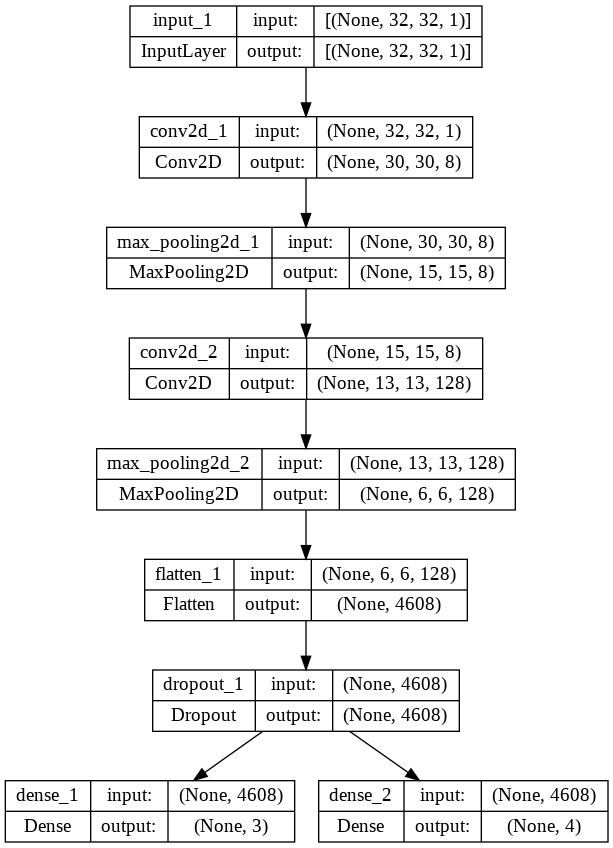

In [ ]:
inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, train_images.shape[3]))
x = Conv2D(8, kernel_size=3, activation="relu")(inputs)
x = MaxPooling2D(pool_size=2)(x)
x = Conv2D(128, kernel_size=3, activation="relu")(x)
x = MaxPooling2D(pool_size=2)(x)

x = Flatten()(x)
x = Dropout(rate=0.4)(x)

output_classification = Dense(units=3, activation="softmax")(x) # Output classification
output_localization = Dense(units=4)(x) # Output localization figures

model = Model(inputs=inputs, outputs=(output_classification, output_localization))

plot_model(model, show_shapes=True, show_layer_names=True)

## 8: Training, evaluating, etc.

Train your new neural network on your new dataset, evaluate it properly, and create a **confusion matrix**.

In [ ]:
tf.config.set_soft_device_placement(True)
tf.debugging.set_log_device_placement(True)

model.compile(optimizer='adam', loss=['categorical_crossentropy', 'mse'], metrics=['accuracy'])
training_history = model.fit(train_images, train_boxes_split, epochs=15, validation_data=(val_images, val_boxes_split), verbose=2)

Epoch 1/15
1875/1875 - 11s - loss: 25.9262 - dense_1_loss: 0.8985 - dense_2_loss: 25.0277 - dense_1_accuracy: 0.5545 - dense_2_accuracy: 0.7515 - val_loss: 15.5512 - val_dense_1_loss: 0.5575 - val_dense_2_loss: 14.9937 - val_dense_1_accuracy: 0.7437 - val_dense_2_accuracy: 0.7991 - 11s/epoch - 6ms/step
Epoch 2/15
1875/1875 - 9s - loss: 15.7255 - dense_1_loss: 0.5266 - dense_2_loss: 15.1989 - dense_1_accuracy: 0.7497 - dense_2_accuracy: 0.8090 - val_loss: 12.8465 - val_dense_1_loss: 0.4270 - val_dense_2_loss: 12.4195 - val_dense_1_accuracy: 0.8172 - val_dense_2_accuracy: 0.8393 - 9s/epoch - 5ms/step
Epoch 3/15
1875/1875 - 9s - loss: 13.7289 - dense_1_loss: 0.4216 - dense_2_loss: 13.3073 - dense_1_accuracy: 0.7989 - dense_2_accuracy: 0.8148 - val_loss: 11.3774 - val_dense_1_loss: 0.3127 - val_dense_2_loss: 11.0646 - val_dense_1_accuracy: 0.8509 - val_dense_2_accuracy: 0.8408 - 9s/epoch - 5ms/step
Epoch 4/15
1875/1875 - 10s - loss: 12.6943 - dense_1_loss: 0.3628 - dense_2_loss: 12.3314 - 

In [ ]:
metrics = model.evaluate(test_images, test_boxes_split)


625/625 [==============================] - 2s 3ms/step - loss: 9.4683 - dense_1_loss: 0.1615 - dense_2_loss: 9.3068 - dense_1_accuracy: 0.9207 - dense_2_accuracy: 0.8751


In [ ]:
classification_prediction, location_prediction = model.predict(test_images)

625/625 [==============================] - 1s 2ms/step


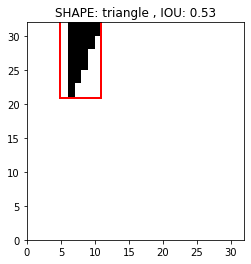

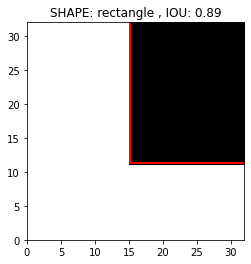

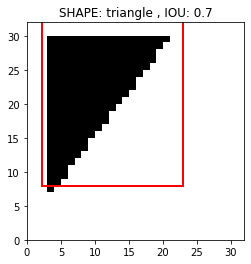

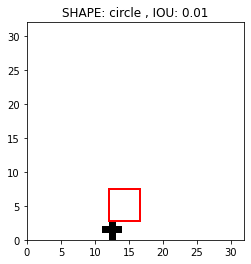

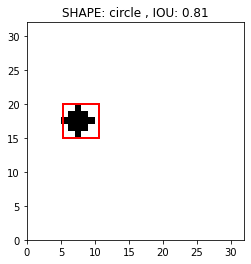

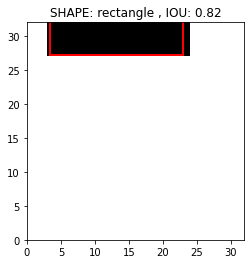

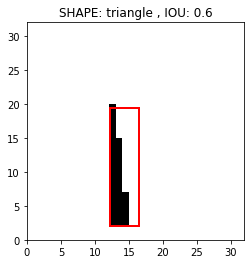

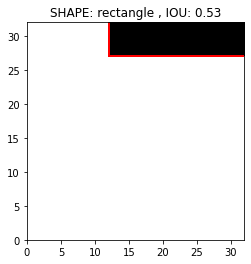

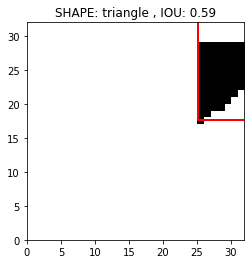

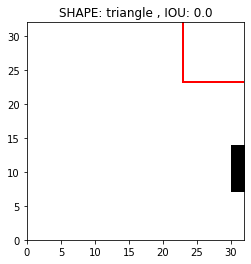

In [ ]:
num_plots=10

for img_idx in range(0, num_plots):
  if round(classification_prediction[img_idx][0], 0) == 1:
        shape_pred = 'rectangle'
  elif round(classification_prediction[img_idx][1], 0) == 1:
        shape_pred = 'circle'
  else:
        shape_pred = 'triangle'

  fig, ax = plt.subplots()
  ax.imshow(check_test_images[img_idx].squeeze()+0.5, cmap='gray', interpolation='none', origin='lower', extent=[0, check_test_images[img_idx].shape[0], 0, check_test_images[img_idx].shape[1]])
  rect = patches.Rectangle((location_prediction[img_idx][0], location_prediction[img_idx][1]), location_prediction[img_idx][2], location_prediction[img_idx][3], ec='r', fc='none', lw=2)
  ax.add_patch(rect)
  ax.title.set_text(f'SHAPE: {shape_pred} , IOU: {iou_metric(location_prediction[img_idx],check_test_boxes[img_idx][3:])}')

  plt.show()

In [ ]:
x = []
for idx in range(0, test_images.shape[0]):
    x.append(iou_metric(location_prediction[idx],check_test_boxes[idx][3:]))

iou_val = sum(x)/test_images.shape[0]

In [ ]:
print('Accuracy: ', metrics[3])
print(f"Mean IoU: {iou_val*100}")

Accuracy:  0.9206960201263428
Mean IoU: 59.55727786389387


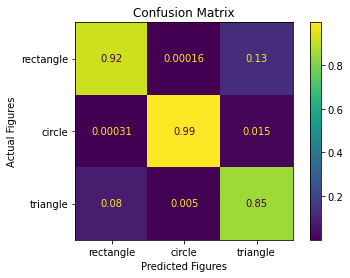

In [ ]:
#Predict
y_prediction = np.argmax(classification_prediction, axis = 1)
y_test=np.argmax(test_boxes[:,:3], axis=1)
#Create confusion matrix and normalizes it over predicted (columns)
cm = confusion_matrix(y_test, y_prediction , normalize='pred')
cmd_obj = ConfusionMatrixDisplay(cm, display_labels=['rectangle', 'circle', 'triangle'])
cmd_obj.plot()
cmd_obj.ax_.set(
                title='Confusion Matrix',
                xlabel='Predicted Figures',
                ylabel='Actual Figures')
plt.show()

## 9: Adding color

Instead of black and white images, generate color images (RGB).

In [ ]:
# Modification: all shapes different colour (see cv2.[shape_name] color parameter)
def generate_figures_images(n_images=1, img_size=(8,8)):

  assert img_size[0] == img_size[1], "The img size  must be a square."

  imgs, label_pos = np.full((n_images, img_size[0], img_size[1], 3), 255.0), np.zeros((n_images, 7))

  # Generate black rectangle
  for n in range(n_images):

    shape = np.random.choice([1,2,3])
    # Generate the rectangle
    if shape == 1:
      # Top left corner
      x, y = randint(2, img_size[0], 2)
      # Width and height
      w, h = randint(2, abs(img_size[0] - x/2)), randint(2, abs(img_size[0] - y/2))
      # Rectangle to image
      pto1, pto2 = (x, y), (x+w, y+h)
      cv2.rectangle(imgs[n], pto1, pto2, (randint(0,255), randint(0,255), randint(0,255)), -1)
      # Save x, y, w, h
      label_pos[n] = np.array([1, 0, 0, float(x), float(y), float(w)+1, float(h)+1])
    else:
          # Generate circle
          if shape == 2:
            # Radius
            radius = int(0.5*randint(2, (img_size[0]/2)-1))
            # Center
            x = randint(radius, img_size[0] - radius)
            y = randint(radius, img_size[0] - radius)
            cv2.circle(imgs[n], (x, y), radius, (randint(0,255), randint(0,255), randint(0,255)), -1)
            # Calculate circle(x, y, w, h)
            label_pos[n] = np.array([0, 1, 0, float(x)-radius, float(y)-radius, float(radius*2)+1, float(radius*2)+1])
          # Generate triangle
          else:
            # Top left corner
            x, y = randint(2, img_size[0], 2)
            # Width and height
            w, h = randint(2, abs(img_size[0] - x/2)), randint(2, abs(img_size[0] - y/2))
            # Points x,y,w,h
            pts = [(x,y), (x+w, y+h), (x+w, y), (x, y+h)]
            # Edges for the triangle
            pts.pop(randint(0, len(pts)-1))
            cv2.drawContours(imgs[n], [np.array(pts)], 0, (randint(0,255), randint(0,255), randint(0,255)), -1)

            label_pos[n] = np.array([0, 0, 1, float(x), float(y), float(w)+1, float(h)+1])


  return imgs, label_pos

In [ ]:
IMG_SIZE = 32
imgs, bx = generate_figures_images(n_images=99999, img_size=(IMG_SIZE,IMG_SIZE))

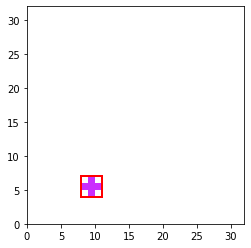

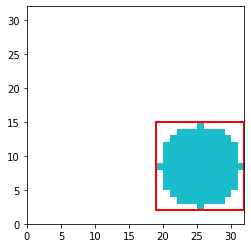

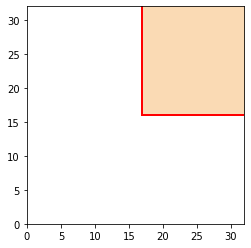

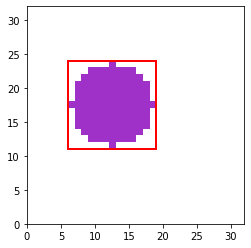

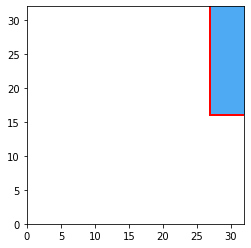

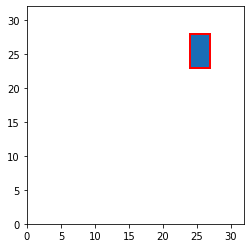

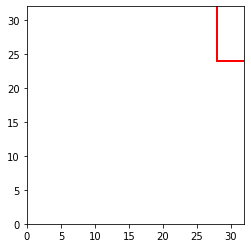

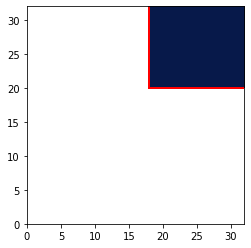

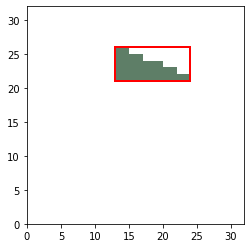

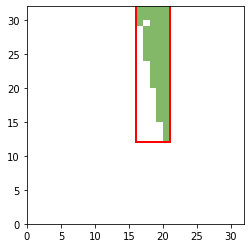

In [ ]:
# Visualize generated images
n_imgs = 10
for idx in range(0,n_imgs):
    fig, ax = plt.subplots()
    ax.imshow(imgs[idx]/255.0, cmap='gray', interpolation='none', origin='lower', extent=[0, imgs[idx].shape[0], 0, imgs[idx].shape[1]])
    rect = patches.Rectangle((bx[idx][3], bx[idx][4]), bx[idx][5], bx[idx][6], ec='r', fc='none', lw=2)
    ax.add_patch(rect)


    plt.show()

In [ ]:
# Normalization of data
w_imgs = (imgs / 255.0) - 0.5

print(f"Images shape: {w_imgs.shape}, images mean: {np.mean(w_imgs)}, images variance: {np.std(w_imgs)}")

Images shape: (99999, 32, 32, 3), images mean: 0.4619886063673765, images variance: 0.15471372362841773


In [ ]:
shuffle_img_location, shuffle_location_label = shuffle(w_imgs,bx, random_state=1)
print(f"Images shape: {shuffle_img_location.shape}, images mean: {np.mean(shuffle_img_location)}, images variance: {np.std(shuffle_img_location)}")
print(f"Location mean: {np.mean(shuffle_location_label)}, Location variance: {np.std(shuffle_location_label)}")

Images shape: (99999, 32, 32, 3), images mean: 0.46198860636737765, images variance: 0.15471372362841812
Location mean: 7.747417474174742, Location variance: 8.663115840073392


In [ ]:
# Split the data of images, labels and their annotations
TRAIN_SIZE = int(shuffle_img_location.shape[0]*0.6)
VAL_TEST_SIZE = int(shuffle_img_location.shape[0]*0.2)

train_images, val_images, test_images, check_test_images = shuffle_img_location[:TRAIN_SIZE], shuffle_img_location[TRAIN_SIZE:TRAIN_SIZE+VAL_TEST_SIZE], shuffle_img_location[-VAL_TEST_SIZE:], shuffle_img_location[-VAL_TEST_SIZE:]
train_boxes, val_boxes, test_boxes, check_test_boxes = shuffle_location_label[:TRAIN_SIZE], shuffle_location_label[TRAIN_SIZE:TRAIN_SIZE+VAL_TEST_SIZE], shuffle_location_label[-VAL_TEST_SIZE:], shuffle_location_label[-VAL_TEST_SIZE:]
print('Train images: ', train_images.shape, ', Train rectangle pos: ', train_boxes.shape)
print('Validation images: ', val_images.shape, ', Validation rectangle pos: ', val_boxes.shape)
print('Test images: ', test_images.shape, ', Test rectangle pos: ', test_boxes.shape)

Train images:  (59999, 32, 32, 3) , Train rectangle pos:  (59999, 7)
Validation images:  (19999, 32, 32, 3) , Validation rectangle pos:  (19999, 7)
Test images:  (19999, 32, 32, 3) , Test rectangle pos:  (19999, 7)


In [ ]:
train_boxes_split = (train_boxes[:,:3], train_boxes[:,3:])
val_boxes_split = (val_boxes[:,:3], val_boxes[:,3:])
test_boxes_split = (test_boxes[:,:3], test_boxes[:,3:])
check_test_boxes_split = (check_test_boxes[:,:3], check_test_boxes[:,3:])

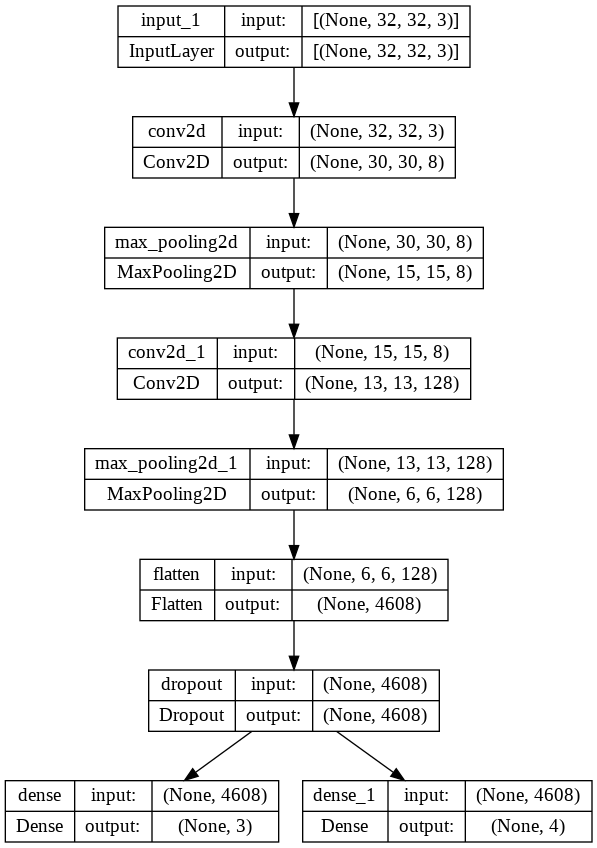

In [ ]:
inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, train_images.shape[3]))
x = Conv2D(8, kernel_size=3, activation="relu")(inputs)
x = MaxPooling2D(pool_size=2)(x)
x = Conv2D(128, kernel_size=3, activation="relu")(x)
x = MaxPooling2D(pool_size=2)(x)

x = Flatten()(x)
x = Dropout(rate=0.4)(x)

output_classification = Dense(units=3, activation="softmax")(x) # Output classification
output_localization = Dense(units=4)(x) # Output localization figures

model = Model(inputs=inputs, outputs=(output_classification, output_localization))

plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
tf.config.set_soft_device_placement(True)
tf.debugging.set_log_device_placement(True)

model.compile(optimizer='adam', loss=['categorical_crossentropy', 'mse'], metrics=['accuracy'])
training_history = model.fit(train_images, train_boxes_split, epochs=15, validation_data=(val_images, val_boxes_split), verbose=2)

Epoch 1/15
1875/1875 - 20s - loss: 30.2632 - dense_loss: 1.0292 - dense_1_loss: 29.2340 - dense_accuracy: 0.4895 - dense_1_accuracy: 0.7160 - val_loss: 20.8692 - val_dense_loss: 0.8737 - val_dense_1_loss: 19.9955 - val_dense_accuracy: 0.5536 - val_dense_1_accuracy: 0.7988 - 20s/epoch - 11ms/step
Epoch 2/15
1875/1875 - 10s - loss: 20.7515 - dense_loss: 0.8983 - dense_1_loss: 19.8532 - dense_accuracy: 0.5727 - dense_1_accuracy: 0.7841 - val_loss: 17.9770 - val_dense_loss: 0.7501 - val_dense_1_loss: 17.2269 - val_dense_accuracy: 0.6531 - val_dense_1_accuracy: 0.7914 - 10s/epoch - 5ms/step
Epoch 3/15
1875/1875 - 11s - loss: 18.7094 - dense_loss: 0.7723 - dense_1_loss: 17.9371 - dense_accuracy: 0.6390 - dense_1_accuracy: 0.7933 - val_loss: 16.7820 - val_dense_loss: 0.6033 - val_dense_1_loss: 16.1786 - val_dense_accuracy: 0.7299 - val_dense_1_accuracy: 0.8219 - 11s/epoch - 6ms/step
Epoch 4/15
1875/1875 - 10s - loss: 17.4381 - dense_loss: 0.6658 - dense_1_loss: 16.7723 - dense_accuracy: 0.686

In [ ]:
metrics = model.evaluate(test_images, test_boxes_split)


625/625 [==============================] - 2s 4ms/step - loss: 11.8060 - dense_loss: 0.2513 - dense_1_loss: 11.5547 - dense_accuracy: 0.8737 - dense_1_accuracy: 0.8567


In [ ]:
classification_prediction, location_prediction = model.predict(test_images)

625/625 [==============================] - 1s 2ms/step


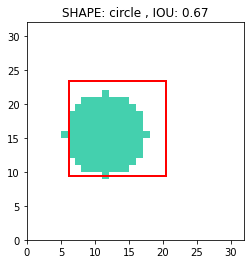

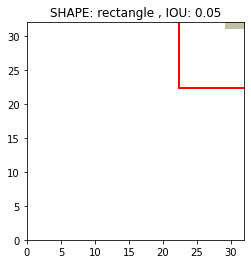

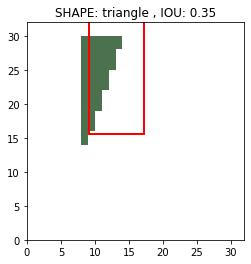

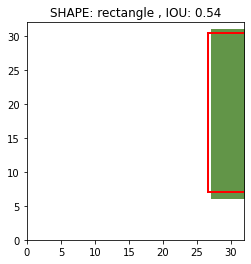

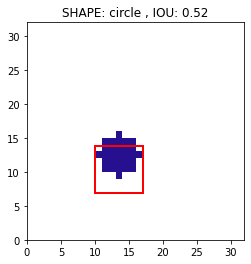

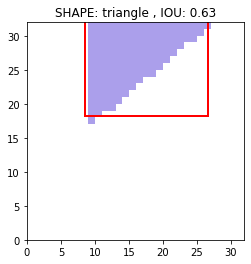

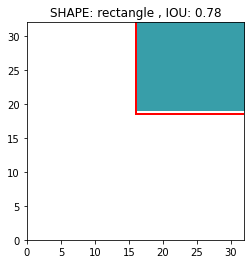

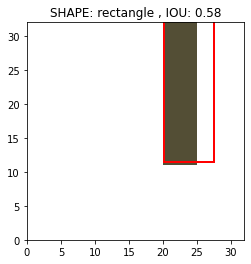

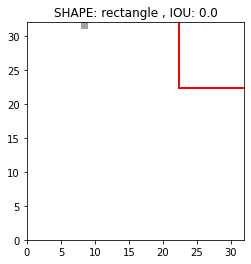

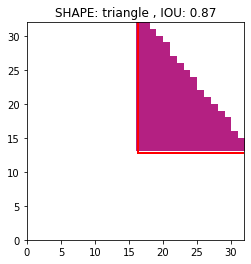

In [ ]:
num_plots=10

for img_idx in range(0, num_plots):
  if round(classification_prediction[img_idx][0], 0) == 1:
        shape_pred = 'rectangle'
  elif round(classification_prediction[img_idx][1], 0) == 1:
        shape_pred = 'circle'
  else:
        shape_pred = 'triangle'

  fig, ax = plt.subplots()
  ax.imshow(check_test_images[img_idx]+0.5, cmap='gray', interpolation='none', origin='lower', extent=[0, check_test_images[img_idx].shape[0], 0, check_test_images[img_idx].shape[1]])
  rect = patches.Rectangle((location_prediction[img_idx][0], location_prediction[img_idx][1]), location_prediction[img_idx][2], location_prediction[img_idx][3], ec='r', fc='none', lw=2)
  ax.add_patch(rect)
  ax.title.set_text(f'SHAPE: {shape_pred} , IOU: {iou_metric(location_prediction[img_idx],check_test_boxes[img_idx][3:])}')

  plt.show()

In [ ]:
x = []
for idx in range(0, test_images.shape[0]):
    x.append(iou_metric(location_prediction[idx],check_test_boxes[idx][3:]))

iou_val = sum(x)/test_images.shape[0]

In [ ]:
print('Accuracy: ', metrics[3])
print(f"Mean IoU: {iou_val*100}")

Accuracy:  0.8736937046051025
Mean IoU: 51.23066153307745


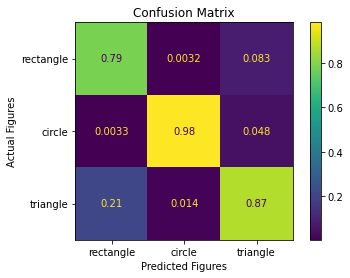

In [ ]:
#Predict
y_prediction = np.argmax(classification_prediction, axis = 1)
y_test=np.argmax(test_boxes[:,:3], axis=1)
#Create confusion matrix and normalizes it over predicted (columns)
cm = confusion_matrix(y_test, y_prediction , normalize='pred')
cmd_obj = ConfusionMatrixDisplay(cm, display_labels=['rectangle', 'circle', 'triangle'])
cmd_obj.plot()
cmd_obj.ax_.set(
                title='Confusion Matrix',
                xlabel='Predicted Figures',
                ylabel='Actual Figures')
plt.show()

# Part 2: Using a pretrained detection model

In this part, you will work with a pre-trained SSD MobileNet model in TensorFlow Lite format.

This is an actual example of what would happen in industry. The model might not always be from your preferred framework, and might not always come with post processing code.

You can download the model from this link https://tfhub.dev/tensorflow/ssd_mobilenet_v1/fpn_640x640/1

![](https://cristianpb.github.io/assets/img/ssd-yolo/main-16x9.jpg)

## 1: Download the model

Download the TFLite model and upload it to colab.

In [ ]:
import tensorflow_hub as hub

In [ ]:
detector = hub.load('https://tfhub.dev/tensorflow/ssd_mobilenet_v1/fpn_640x640/1')

## 2: Run an inference using the model

Find an image and give it to the model in the correct format.

If you are using the TFLite model directly, use tflite for inference. Otherwise use the framework of your choice.

In [ ]:
import tempfile
from urllib.request import urlopen
from io import BytesIO
from PIL import Image, ImageOps, ImageDraw, ImageColor, ImageFont


def display_image(image):
  fig = plt.figure(figsize=(20, 15))
  plt.grid(False)
  plt.imshow(image)


def download_and_resize_image(url, new_width=256, new_height=256, display=False):
  _, filename = tempfile.mkstemp(suffix=".JPG")
  response = urlopen(url)
  image_data = response.read()
  image_data = BytesIO(image_data)
  pil_image = Image.open(image_data)
  pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS)
  pil_image_rgb = pil_image.convert("RGB")

  return pil_image_rgb

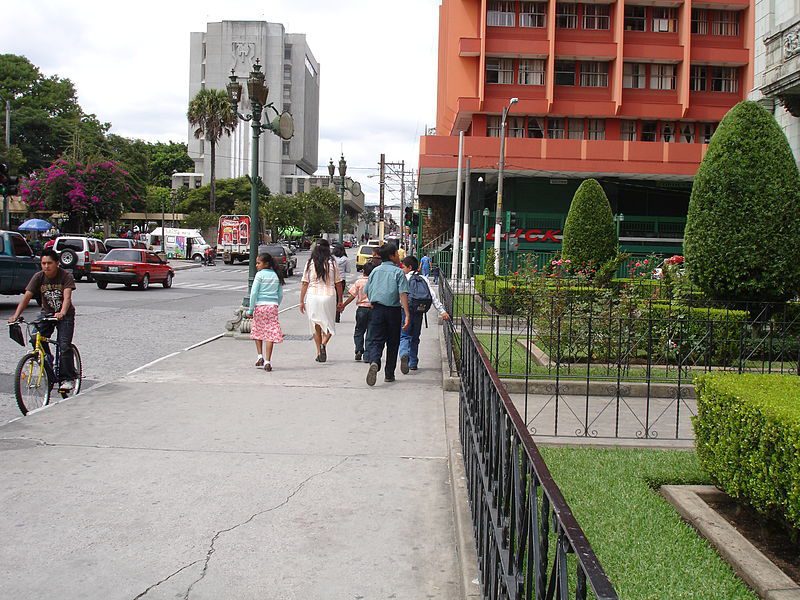

In [ ]:
img_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/d/d4/Caminando.JPG/800px-Caminando.JPG"
downloaded_image = download_and_resize_image(img_url, 800, 600, True)
downloaded_image #= Image.open("/content/hola.png").convert("RGB")

In [ ]:
converted_img = tf.image.convert_image_dtype(np.array(downloaded_image), tf.uint8)[tf.newaxis, ...]
result = detector(converted_img)
result = {key:value.numpy() for key,value in result.items()}
print(result.keys())

dict_keys(['detection_multiclass_scores', 'num_detections', 'detection_scores', 'detection_anchor_indices', 'raw_detection_boxes', 'detection_classes', 'raw_detection_scores', 'detection_boxes'])


## 3: Write the post processing code


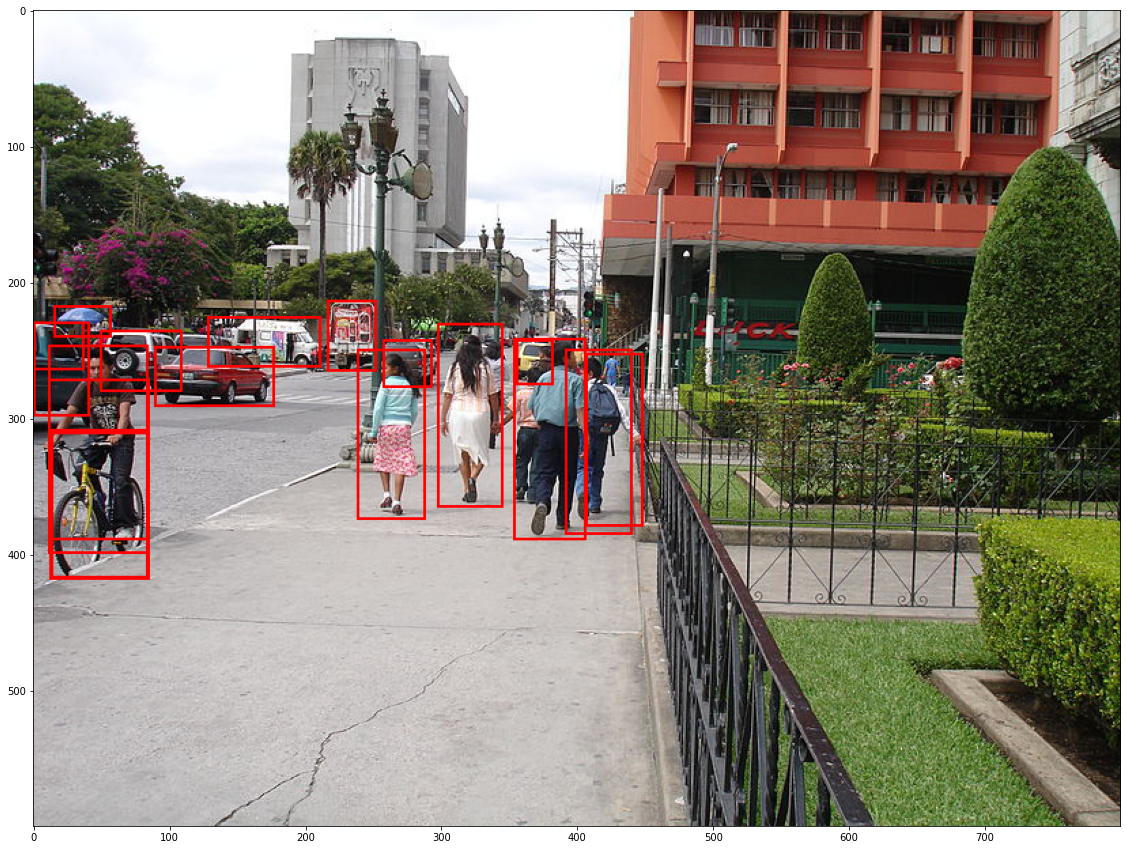

In [ ]:
boxes = result["detection_boxes"]
scores = result["detection_scores"]
max_boxes = 50
min_score=0.3

for i in range(min(boxes.shape[1], max_boxes)):
  if scores[0][i] >= min_score:
    ymin, xmin, ymax, xmax = tuple(boxes[0][i])
    draw = ImageDraw.Draw(downloaded_image)
    im_width, im_height = downloaded_image.size
    (left, right, top, bottom) = (xmin * im_width, xmax * im_width, ymin * im_height, ymax * im_height)
    draw.line([(left, top), (left, bottom), (right, bottom), (right, top), (left, top)], width=2, fill='red')


display_image(downloaded_image)